In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt




In [52]:
headers = ["Buying Price", "Maintanence", "#Doors", "#Persons", "Trunk Size", "Safety", "Acceptability"]
data = pd.read_csv('car_data/car.data', header = None, names = headers)
data.head()

,Buying Price,Maintanence,#Doors,#Persons,Trunk Size,Safety,Acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [53]:
print(data.dtypes)

Buying Price     object
Maintanence      object
#Doors           object
#Persons         object
Trunk Size       object
Safety           object
Acceptability    object
dtype: object


In [54]:
lb_Make = LabelEncoder()
data["Buying Price"] = lb_Make.fit_transform(data["Buying Price"])
data["Maintanence"] = lb_Make.fit_transform(data["Maintanence"])
data["#Doors"] = lb_Make.fit_transform(data["#Doors"])
data["#Persons"] = lb_Make.fit_transform(data["#Persons"])
data["Trunk Size"] = lb_Make.fit_transform(data["Trunk Size"])
data["Safety"] = lb_Make.fit_transform(data["Safety"])
data["Acceptability"] = lb_Make.fit_transform(data["Acceptability"])
data.head()

,Buying Price,Maintanence,#Doors,#Persons,Trunk Size,Safety,Acceptability
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [55]:
data = data.values


data[data[:,6] == 0,6] = 1
data[data[:,6] == 1,6] = 1
data[data[:,6] == 3,6] = 1
data[data[:,6] == 2,6] = 0

print(data[0:5,:])

[[3 3 0 0 2 1 0]
 [3 3 0 0 2 2 0]
 [3 3 0 0 2 0 0]
 [3 3 0 0 1 1 0]
 [3 3 0 0 1 2 0]]


In [56]:
#split data
breakNum = int(0.8*len(data))

X_train_val = data[:breakNum,:6]
Y_train_val = data[:breakNum,6]
X_test = data[breakNum:,:6]
Y_test = data[breakNum:,6]

print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(1382, 6) (346, 6) (1382,) (346,)


CLASSIFICATION

In [59]:
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42)
}

# store results
results = {}

# define partitions
partitions = [0.8, 0.5, 0.2]  # Training sizes: 80%, 50%, 20%

# iterate over partitions
for train_size in partitions:
    test_size = 1 - train_size
    print(f"\nPartition: {int(train_size*100)}% Training, {int(test_size*100)}% Testing")
    
    # split training and testing data
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, Y_train_val, train_size=train_size, random_state=42)
    
    # evaluate each classifier
    for clf_name, clf in classifiers.items():
        print(f"\nClassifier: {clf_name}")
        
        # Hyperparameter tuning
        if clf_name == 'RandomForest':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
        elif clf_name == 'LogisticRegression':
            param_grid = {
                'C': [0.01, 0.1, 1, 10],
                'penalty': ['l2']
            }
        elif clf_name == 'SVM':
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto']
            }
        else:
            param_grid = {}

        # perform grid search with cross-validation
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        # best estimator and performance
        best_clf = grid_search.best_estimator_
        y_pred_val = best_clf.predict(X_val)
        y_pred_test = best_clf.predict(X_test)
        
        # store results
        accuracy_val = accuracy_score(y_val, y_pred_val)
        accuracy_test = accuracy_score(Y_test, y_pred_test)
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Validation Accuracy: {accuracy_val:.4f}")
        print(f"Test Accuracy: {accuracy_test:.4f}")
        print("Classification Report (Test Data):")
        print(classification_report(Y_test, y_pred_test))
        
        # save results
        results[(clf_name, train_size)] = {
            'best_params': grid_search.best_params_,
            'validation_accuracy': accuracy_val,
            'test_accuracy': accuracy_test,
            'classification_report': classification_report(Y_test, y_pred_test, output_dict=True)
        }

output_file = "car_eval_results.json"
with open(output_file, "w") as file:
    json.dump(results_with_string_keys, file, indent=4)

print(f"Results saved to {output_file}")


Partition: 80% Training, 19% Testing

Classifier: RandomForest
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Validation Accuracy: 0.9856
Test Accuracy: 0.9104
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       198
           1       1.00      0.79      0.88       148

    accuracy                           0.91       346
   macro avg       0.93      0.90      0.91       346
weighted avg       0.92      0.91      0.91       346


Classifier: LogisticRegression
Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Validation Accuracy: 0.7581
Test Accuracy: 0.6358
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.63      0.90      0.74       198
           1       0.68      0.28      0.40       148

    accuracy                           0.64       346
   macro avg       0.65      0.59      0.57       346
weighted a

NameError: name 'json' is not defined

/var/folders/c1/tcshx8gx5qjfjjxf4cwhb_gc0000gn/T/ipykernel_22445/681277610.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Acceptability", palette="pastel")


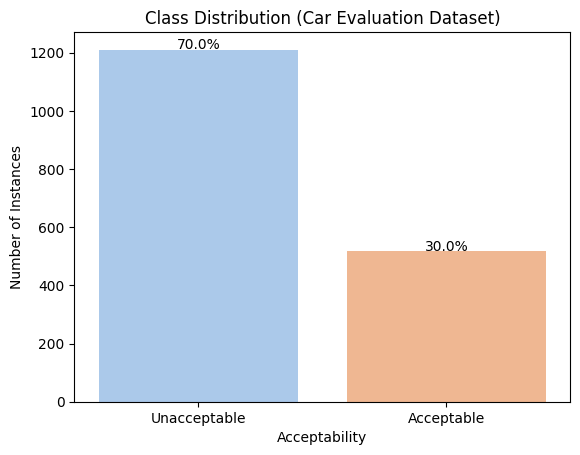

In [58]:
sns.countplot(data=df, x="Acceptability", palette="pastel")
plt.title("Class Distribution (Car Evaluation Dataset)")
plt.xlabel("Acceptability")
plt.ylabel("Number of Instances")
plt.xticks(ticks=[0, 1], labels=["Unacceptable", "Acceptable"])
total = len(df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.gca().text(p.get_x() + p.get_width() / 2., p.get_height() + 2, percentage, ha='center')
plt.show()